In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std



plt.rc("axes.spines", top=False, right=False)


import wrangle
import split_scale
import evaluate

Accuire Data

In [2]:
from env import host, user, password

In [81]:
#data for baseline model
df=wrangle.get_data_from_mysql()

In [19]:
df_base=df

In [82]:
#data for tax rate distribution
df_tax = wrangle.taxcounty()

In [83]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate
0,498347.0,6037.0,6089.82,0.0122
1,549917.0,6037.0,6679.55,0.0121
2,235272.0,6037.0,3876.31,0.0165
3,340000.0,6037.0,4206.15,0.0124
4,2017254.0,6037.0,24353.42,0.0121


Clean Data

In [85]:
df_base = df.filter(['bedrooms','bathrooms','sqft', 'tax_value'], axis=1)

In [86]:
df_base.head()

,bedrooms,bathrooms,sqft,tax_value
0,4.0,2.0,1604.0,498347.0
1,3.0,3.0,2384.0,549917.0
2,3.0,2.0,1574.0,235272.0
3,2.0,2.0,1619.0,340000.0
4,2.0,3.0,2408.0,2017254.0


In [38]:
df_base.describe()

,bedrooms,bathrooms,sqft,tax_value
count,15669.000000,15669.000000,15669.000000,1.566900e+04
mean,3.247750,2.204895,1826.649244,4.605711e+05
std,0.945078,1.019685,972.427738,6.422877e+05
min,1.000000,1.000000,320.000000,7.584000e+03
25%,3.000000,2.000000,1232.000000,1.803100e+05
50%,3.000000,2.000000,1586.000000,3.169390e+05
75%,4.000000,3.000000,2142.000000,5.250000e+05
max,25.000000,20.000000,26345.000000,1.912982e+07


In [22]:
#acquiring county names based on fips field
#from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angeles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

In [23]:
df_tax.head()
df_tax.describe()

,tax_value,fips,taxamount,tax_rate
count,1.595600e+04,15956.000000,15956.000000,15956.000000
mean,4.634078e+05,6044.487591,5681.839846,0.013342
std,6.434229e+05,17.283469,7466.645847,0.003730
min,1.216800e+04,6037.000000,49.180000,0.000000
25%,1.820338e+05,6037.000000,2496.027500,0.011900
50%,3.205150e+05,6037.000000,4065.150000,0.012500
75%,5.286050e+05,6037.000000,6409.490000,0.013700
max,1.912982e+07,6111.000000,228999.210000,0.155100


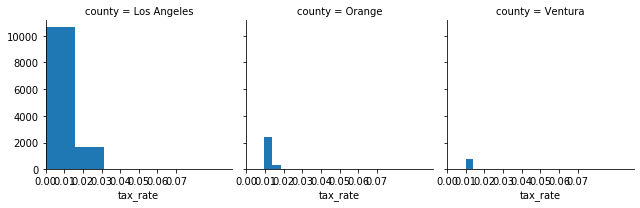

In [24]:
#Tax distribution by county.

from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.1)
plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

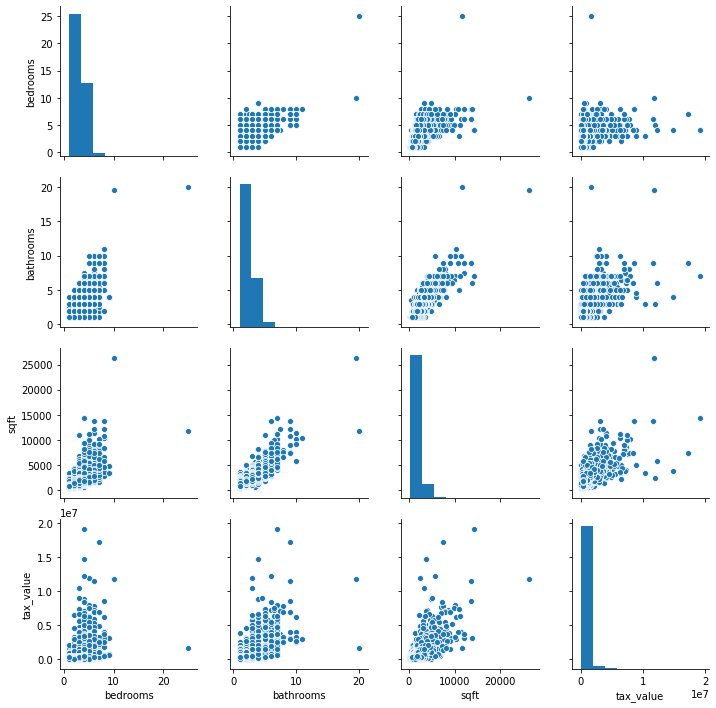

In [39]:
sns.pairplot(df_base)

Split and Scale

In [87]:
train, test = split_scale.split_my_data(df_base,train_ratio=.8,seed=123)

In [88]:
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

In [ ]:
Explore

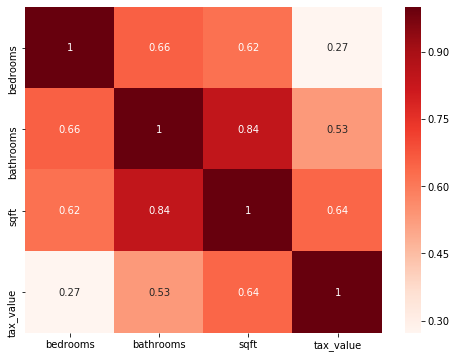

In [89]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [90]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [91]:
#r2 of 
r2_lm1_base = r2_score(y_train,train.yhat)
r2_lm1_base

0.4395114114030475

In [92]:
#creating baseline with mean of tax value
train['tax_value'] = train.tax_value.mean()
train.head()

,bedrooms,bathrooms,sqft,tax_value,yhat
3396,1.0,1.0,728.0,458742.778301,214925.802417
9893,4.0,2.0,1839.0,458742.778301,348504.233813
6069,3.0,2.0,1635.0,458742.778301,395944.568526
14615,4.0,3.0,2131.0,458742.778301,526535.769063
3172,2.0,1.0,1411.0,458742.778301,393952.734547


In [93]:
#creating residual of tax value vs expected tax value
train['residual'] = train['yhat'] - train['tax_value']
train['residual2'] = train.residual **2

In [94]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,yhat,residual,residual2
3396,1.0,1.0,728.0,458742.778301,214925.802417,-243816.975883,5.944672e+10
9893,4.0,2.0,1839.0,458742.778301,348504.233813,-110238.544488,1.215254e+10
6069,3.0,2.0,1635.0,458742.778301,395944.568526,-62798.209775,3.943615e+09
14615,4.0,3.0,2131.0,458742.778301,526535.769063,67792.990762,4.595890e+09
3172,2.0,1.0,1411.0,458742.778301,393952.734547,-64790.043753,4.197750e+09


MVP

In [95]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm = LinearRegression()

In [96]:
#fit and train model
lm.fit(X_train,y_train)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

tax_value = b + m1 * bedrooms + m2 * bathrooms
    y-intercept  (b): -25353.09
    coefficient (m1): -143889.86
    coefficient (m2): 39976.33


In [97]:
#converting y_train Series
y_train = y_train.tax_value

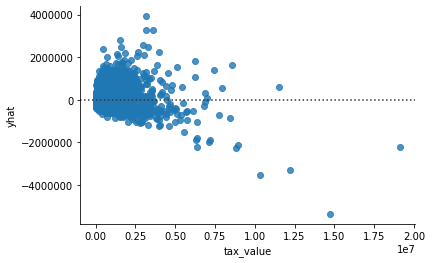

In [98]:
#Residuals
sns.residplot(y_train,train.yhat)

In [178]:
#MSE, SSE, RMSE
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

2158138796829235.0 172169030461.04785 414932.5613410544 0.4138937083814628


In [118]:
print("R_base= ", r2)

R_base=  0.4395114114030475


Text(0.5, 1, 'Predicted vs Actual Tax Value')

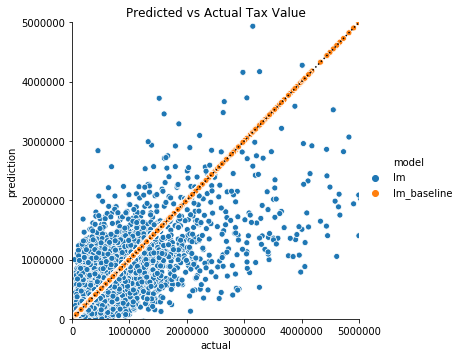

In [63]:
pd.DataFrame({'actual': y_train,
              'lm': train.yhat,
              'lm_baseline': train.tax_value})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [179]:
print("R_base= ", r2)

R_base=  0.4138937083814628


In [180]:
mse_lm = mean_squared_error(y_train,train.tax_value)
print("linear model\n  mean squared error: {:.3}".format(mse_lm)) 

linear model
  mean squared error: 3.92e+11


1st feature, just using OC data 

In [103]:
df_oc = df_base[df_tax.fips==6059]

In [104]:
df_oc.head()

,bedrooms,bathrooms,sqft,tax_value
15,4.0,2.0,1444.0,479778.0
16,2.0,2.0,949.0,50102.0
17,2.0,2.0,1090.0,290614.0
18,4.0,3.0,2505.0,829744.0
25,5.0,3.5,4958.0,465753.0


Explore Los Angeles, with base data

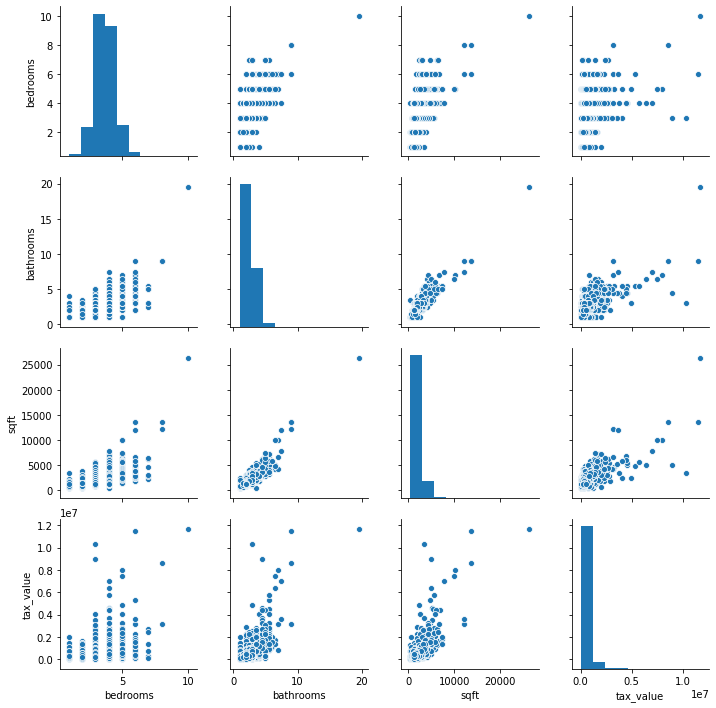

In [105]:
sns.pairplot(df_oc)

Split OC Data

In [110]:
train_oc, test_oc = split_scale.split_my_data(df_oc,train_ratio=.8,seed=123)

In [112]:
X_train_oc = train_oc.drop(columns='tax_value')
y_train_oc = train_oc[['tax_value']]
X_test_oc = test_oc.drop(columns='tax_value')
y_test_oc = test_oc[['tax_value']]

In [113]:
train_oc.head()

,bedrooms,bathrooms,sqft,tax_value
8417,5.0,4.0,3329.0,858895.0
7616,5.0,3.0,2744.0,582531.0
7811,3.0,2.5,1936.0,421958.0
9589,4.0,2.5,1991.0,94370.0
6683,3.0,1.0,993.0,398212.0


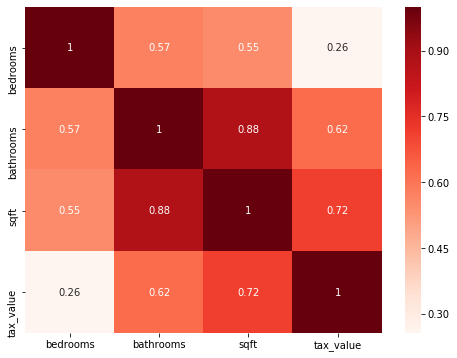

In [114]:
plt.figure(figsize=(8,6))
cor = train_oc.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [116]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train_oc ~ X_train_oc',data=train_oc).fit()
train_oc['yhat_oc'] = ols_model.predict(y_train_oc)

In [117]:
#r2 of 
r2_lm1_la = r2_score(y_train_oc,train_oc.yhat_oc)
r2_lm1_la

0.5400581047329245

In [119]:
print("r_OC ", r2_lm1_la )

r_OC  0.5400581047329245


MVP vs just using LA county information

In [120]:
#creating baseline with mean of tax value
train_oc['tax_value'] = train_oc.tax_value.mean()
train_oc.head()

,bedrooms,bathrooms,sqft,tax_value,yhat_oc
8417,5.0,4.0,3329.0,550200.62545,957927.913270
7616,5.0,3.0,2744.0,550200.62545,629619.998647
7811,3.0,2.5,1936.0,550200.62545,550574.073609
9589,4.0,2.5,1991.0,550200.62545,409404.541023
6683,3.0,1.0,993.0,550200.62545,26253.674782


In [122]:
#creating residual of tax value vs expected tax value
train_oc['residual_oc'] = train_oc['yhat_oc'] - train_oc['tax_value']
train_oc['residual2_oc'] = train_oc.residual_oc **2

Evaluate

In [123]:
 #fit and train model
lm.fit(X_train_oc,y_train_oc)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train_oc.columns[0], X_train_oc.columns[0],X_train_oc.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

tax_value = b + m1 * bedrooms + m2 * bathrooms
    y-intercept  (b): 3261.66
    coefficient (m1): -167920.97
    coefficient (m2): 43769.93


In [124]:
#converting y_train Series
y_train_oc= y_train_oc.tax_value

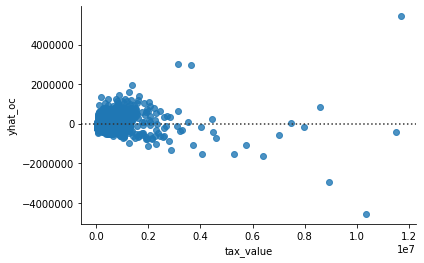

In [125]:
#Residuals
sns.residplot(y_train_oc,train_oc.yhat_oc)

In [126]:
#MSE, SSE, RMSE
import math
sse_oc = sum(train_oc.residual2_oc)
mse_oc = sse_oc/len(train_oc)
rmse_oc = math.sqrt(mse_oc)
r2_oc= ols_model.rsquared
print(sse_oc,mse_oc,rmse_oc,r2_oc)

633983680097109.4 285064604360.21106 533914.4167001029 0.5400581047329245


In [127]:
print("R_oc= ", r2_oc)


R_oc=  0.5400581047329245


Text(0.5, 1, 'Predicted vs Actual Tax Value ')

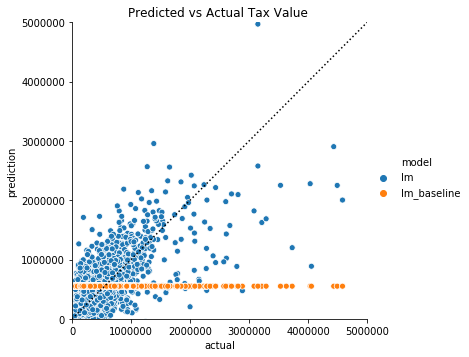

In [147]:
pd.DataFrame({'actual': y_train_oc,
              'lm': train_oc.yhat_oc,
              'lm_baseline': train_oc.tax_value})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value ')

LA

In [159]:
df_la = df_base[df_tax.fips==6037]

In [161]:
df_la.head()

,bedrooms,bathrooms,sqft,tax_value
0,4.0,2.0,1604.0,498347.0
1,3.0,3.0,2384.0,549917.0
2,3.0,2.0,1574.0,235272.0
3,2.0,2.0,1619.0,340000.0
4,2.0,3.0,2408.0,2017254.0


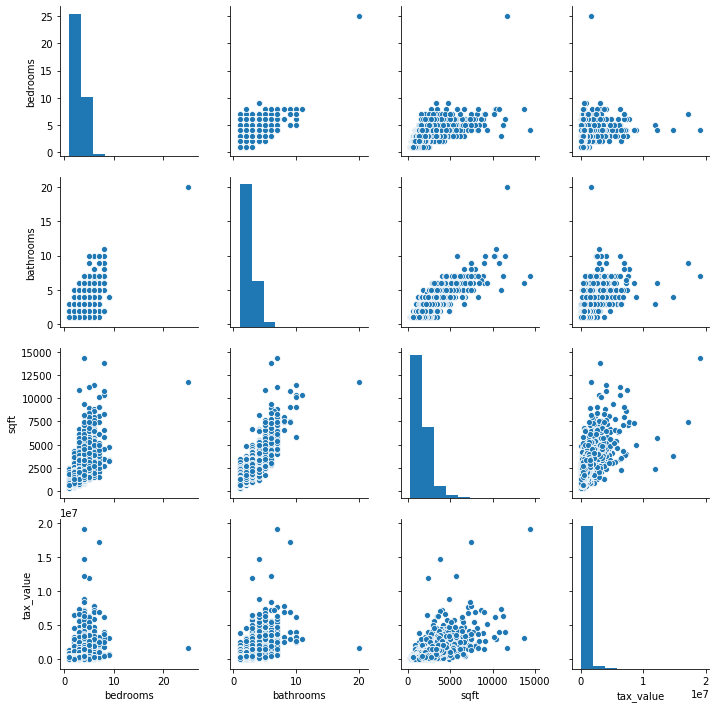

In [109]:
sns.pairplot(df_la)

In [162]:
train_la, test_la = split_scale.split_my_data(df_la,train_ratio=.8,seed=123)

In [163]:
X_train_la = train_la.drop(columns='tax_value')
y_train_la = train_la[['tax_value']]
X_test_la = test_la.drop(columns='tax_value')
y_test_la = test_la[['tax_value']]

In [164]:
train_la.head()

,bedrooms,bathrooms,sqft,tax_value
5671,2.0,1.0,883.0,336932.0
5739,3.0,1.0,1224.0,33293.0
2653,2.0,1.0,923.0,60637.0
700,3.0,3.0,1338.0,101580.0
12832,3.0,2.0,1921.0,305855.0


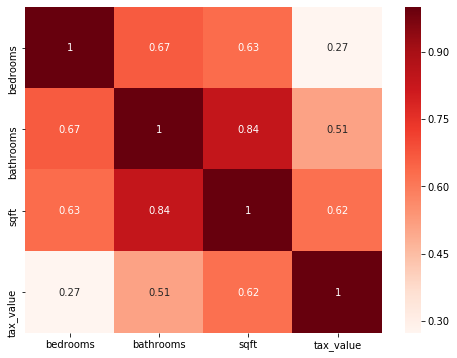

In [165]:
plt.figure(figsize=(8,6))
cor = train_la.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [166]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train_la ~ X_train_la',data=train_la).fit()
train_la['yhat_la'] = ols_model.predict(y_train_la)

In [167]:
#r2 of 
r2_lm1_la = r2_score(y_train_la,train_la.yhat_la)
r2_lm1_la

0.4138937083814628

In [168]:
#creating baseline with mean of tax value
train_la['tax_value'] = train_la.tax_value.mean()
train_la.head()

,bedrooms,bathrooms,sqft,tax_value,yhat_la
5671,2.0,1.0,883.0,441036.592872,147224.659033
5739,3.0,1.0,1224.0,441036.592872,170969.957910
2653,2.0,1.0,923.0,441036.592872,166493.377213
700,3.0,3.0,1338.0,441036.592872,298141.767907
12832,3.0,2.0,1921.0,441036.592872,542855.353784


MVP vs just using LA county information

In [170]:
#creating baseline with mean of tax value
train_la['tax_value'] = train_la.tax_value.mean()
train_la.head()

,bedrooms,bathrooms,sqft,tax_value,yhat_la,residual_la,residual2_la
5671,2.0,1.0,883.0,441036.592872,147224.659033,-293811.933839,8.632545e+10
5739,3.0,1.0,1224.0,441036.592872,170969.957910,-270066.634962,7.293599e+10
2653,2.0,1.0,923.0,441036.592872,166493.377213,-274543.215659,7.537398e+10
700,3.0,3.0,1338.0,441036.592872,298141.767907,-142894.824965,2.041893e+10
12832,3.0,2.0,1921.0,441036.592872,542855.353784,101818.760912,1.036706e+10


In [172]:
#creating residual of tax value vs expected tax value
train_la['residual_la'] = train_la['yhat_la'] - train_la['tax_value']
train_la['residual2_la'] = train_la.residual_la **2
print ("it works")

it works


In [173]:
 #fit and train model
lm.fit(X_train_la,y_train_la)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train_la.columns[0], X_train_la.columns[0],X_train_la.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

tax_value = b + m1 * bedrooms + m2 * bathrooms
    y-intercept  (b): -33219.23
    coefficient (m1): -140520.52
    coefficient (m2): 36127.98


In [174]:
 #converting y_train Series
y_train_la= y_train_la.tax_value

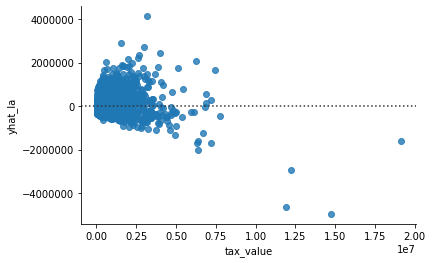

In [175]:
#Residuals
sns.residplot(y_train_la,train_la.yhat_la)

In [176]:
#MSE, SSE, RMSE
import math
sse_la = sum(train_la.residual2_la)
mse_la = sse_la/len(train_la)
rmse_la = math.sqrt(mse_la)
r2_la= ols_model.rsquared
print(sse_la,mse_la,rmse_la,r2_la)

1542478239695647.2 159346925588.3933 399182.8222611706 0.4138937083814628


In [177]:
print("R_la= ", r2_la)



R_la=  0.4138937083814628


Text(0.5, 1, 'Predicted vs Actual Tax Value')

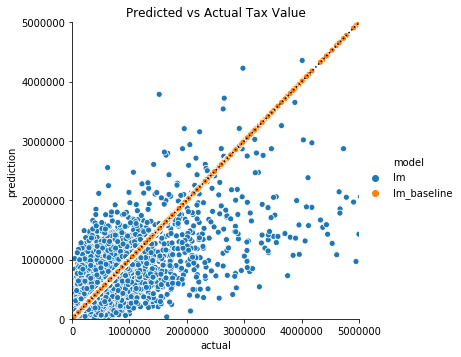

In [145]:
pd.DataFrame({'actual': y_train_la,
              'lm': train_la.yhat_la,
              'lm_baseline': train_la.tax_value})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')